In [93]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/topic-classification-dataset/topic_classification_data.csv
/kaggle/input/topic-classification-dataset/2CLEAN.csv


In [94]:
import re
import os
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer  
stop_words = stopwords.words('english')
nltk.download('wordnet')

import tensorflow as tf
from sklearn import preprocessing
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [95]:
df = pd.read_csv(r'/kaggle/input/topic-classification-dataset/topic_classification_data.csv')
df.head()


,Unnamed: 0,content,label
0,0,I'm struggling to understand how I feel about ...,Emotion
1,1,NEW: Modi's promise to ban plastic straws this...,Financial
2,2,SURVEY: Middle-Income Americans Spending Less ...,Financial
3,3,WATCH: Wall Street ended lower after bank stoc...,Financial
4,4,Someone selling a ton of $SE puts to open Sep ...,Financial


In [96]:
df.tail()

,Unnamed: 0,content,label
136798,136798,Ehlers-Danlos syndrome (EDS) is a group of inh...,Health
136799,136799,i feel tortured being a person because no one ...,Emotion
136800,136800,Aicardi-Goutieres syndrome is an inherited con...,Health
136801,136801,i feel really successful for the fact that i r...,Emotion
136802,136802,i feel that youve got to be fearless as an art...,Emotion


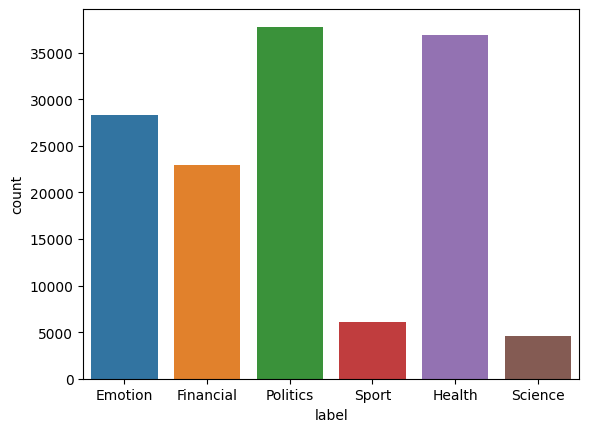

In [97]:
ax = sns.countplot(x="label", data=df)

In [98]:
df = df.drop(['Unnamed: 0'] , axis=1)
print(len(df))

136803


In [99]:
df.head()

,content,label
0,I'm struggling to understand how I feel about ...,Emotion
1,NEW: Modi's promise to ban plastic straws this...,Financial
2,SURVEY: Middle-Income Americans Spending Less ...,Financial
3,WATCH: Wall Street ended lower after bank stoc...,Financial
4,Someone selling a ton of $SE puts to open Sep ...,Financial


In [100]:
from nltk.corpus import stopwords

sw = stopwords.words('english')


In [101]:
from nltk.stem.wordnet  import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [102]:
nltk.download('wordnet','/kaggle/working/nltk_data/')

[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data/...
[nltk_data]   Package wordnet is already up-to-date!


True

In [103]:
!python3 -m nltk.downloader wordnet
!unzip /kaggle/working/nltk_data/corpora/wordnet.zip -d /kaggle/working/nltk_data/corpora/

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /kaggle/working/nltk_data/corpora/wordnet.zip
replace /kaggle/working/nltk_data/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [104]:
nltk.data.path.append('/kaggle/working/nltk_data/')

In [105]:
def clean_text(text):

    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", str(text)) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs 
    #text = re.sub(r"http", "",text)
    
    html=re.compile(r'<.*?>') 
    
    text = html.sub(r'',text) #Removing html tags
    
    punctuations = '@#!?+&*[]-%.:/();$=><,|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations
        
    text = ''.join([i for i in text if not i.isdigit()])
        
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    
    text = [lemmatizer.lemmatize(word) for word in text]
    
    #text = [stemmer.stem(word) for word in text]
        
    text = " ".join(text) #removing stopwords
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis

    return text 

In [106]:
df['content'] = df['content'].apply(lambda x: clean_text(x))
 
df.head()

,content,label
0,struggling understand feel someone want opinio...,Emotion
1,new modi promise ban plastic straw month put i...,Financial
2,survey middle income american spending le amid...,Financial
3,watch wall street ended lower bank stock erase...,Financial
4,someone selling ton se put open sep nov,Financial


In [107]:
df['content'].head(10)

0    struggling understand feel someone want opinio...
1    new modi promise ban plastic straw month put i...
2    survey middle income american spending le amid...
3    watch wall street ended lower bank stock erase...
4              someone selling ton se put open sep nov
5    mccoy told story whiskey obliged buy next roun...
6    past month protest erupted hall u capital stre...
7    patient forced procedure second trimester clin...
8    making large campaign donation candidate offic...
9    really court job intervene political fightsupr...
Name: content, dtype: object

In [108]:
sample_corpora = df['content'].iloc[:2].values
sample_corpora

array(['struggling understand feel someone want opinion think line drawn two',
       'new modi promise ban plastic straw month put india lead region curbing pollution many beverage maker ready tco v hhnenb'],
      dtype=object)

In [109]:
index = 0
for x in df['content']:
    if len(x)>1500 or len(x) == 0:
        df['content'] = df['content'].drop(index , axis = 0)
    index = index +1

In [110]:
lens = df['content'].str.len()
lenss = lens.sort_values()
print(lenss)

79075     1.0
109966    1.0
3465      1.0
64250     1.0
112260    1.0
         ... 
136468    NaN
136538    NaN
136652    NaN
136670    NaN
136693    NaN
Name: content, Length: 136803, dtype: float64


In [111]:
df =df.dropna()
print(len(df))

133784


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133784 entries, 0 to 136802
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   content  133784 non-null  object
 1   label    133784 non-null  object
dtypes: object(2)
memory usage: 3.1+ MB


In [113]:
lens = df['content'].str.len()
lenss = lens.sort_values()
print(lenss)

79075        1
109966       1
3465         1
64250        1
112260       1
          ... 
39624     1498
111092    1498
34905     1499
57609     1499
51233     1500
Name: content, Length: 133784, dtype: int64


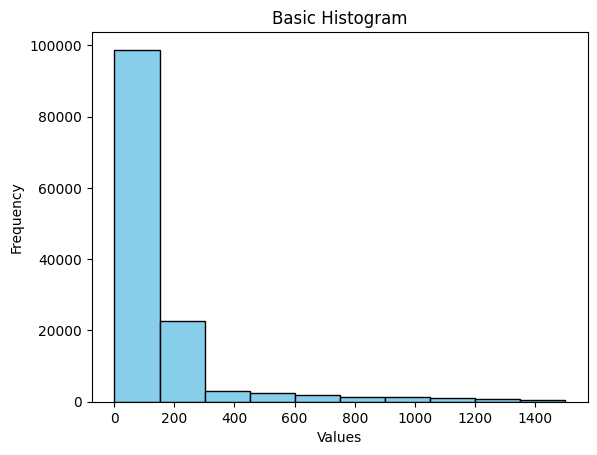

In [114]:
# Plotting a basic histogram
plt.hist(lenss, bins=10, color='skyblue', edgecolor='black')
 
# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Basic Histogram')
 
# Display the plot
plt.show()

In [115]:
X_train, X_test , y_train, y_test = train_test_split(df['content'].values,
                                                     df['label'].values,test_size=0.2,random_state=123,
                                                     stratify=df['label'].values)

In [116]:
print(len(X_train))

107027


In [117]:
df.content.apply(lambda x: len(x.split(" "))).mean()

22.302113855169527

In [118]:
X_train = list(X_train)

In [119]:
MAX_FEATURES = 117224
EMBED_SIZE = 50
RNN_CELL_SIZE = 32
MAX_LEN = 150   
vocab_size = 117224

In [120]:
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(X_train)
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
vocab_size = len(tokenizer.word_index) + 1
print('vocab_size :', vocab_size)
X_train = pad_sequences(list_tokenized_train, maxlen=MAX_LEN)
y_train = y_train

vocab_size : 117224


In [121]:
print(type(X_train))
print(type(y_train))
#print(X_train[0])

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [122]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
 
    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
 
        return context_vector, attention_weights

In [123]:
ixtoword = {} # index to word dic
wordtoix = {} # word to index dic

tokenizer.word_index['<PAD0>'] = 0 # no word in vocab has index 0. but padding is indicated with 0
wordtoix = tokenizer.word_index # word to index dic

for w in tokenizer.word_index:
    ixtoword[tokenizer.word_index[w]] = w
print(len(ixtoword))
print(len(wordtoix))

117224
117224


In [124]:
import pickle

# saving
with open('/kaggle/working/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle)

# loading
with open('/kaggle/working/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [142]:
import pickle

# saving
with open('/kaggle/working/ixtoword.pickle', 'wb') as handle:
    pickle.dump(ixtoword, handle)

# loading
with open('/kaggle/working/ixtoword.pickle', 'rb') as handle:
    ixtoword = pickle.load(handle)

In [143]:
import pickle

# saving
with open('/kaggle/working/wordtoix.pickle', 'wb') as handle:
    pickle.dump(wordtoix, handle)

# loading
with open('/kaggle/working/wordtoix.pickle', 'rb') as handle:
    wordtoix = pickle.load(handle)

In [125]:
def make_embedding_layer(embedding_dim=50, glove=True):
    if glove == False:
        print('Just a zero matrix loaded')
        embedding_matrix = np.zeros((vocab_size, embedding_dim)) # just a zero matrix
    else:
        glove_dir = r'/kaggle/working/'
        embeddings_index = {}
        f = open(os.path.join(glove_dir, 'glove.6B.'+str(embedding_dim)+'d.txt'), encoding="utf-8")
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        # Get x-dim dense vector for each of the vocab_rocc
        embedding_matrix = np.zeros((vocab_size, embedding_dim)) # to import as weights for Keras Embedding layer
        for word, i in wordtoix.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words not found in the embedding index will be all zeros
                embedding_matrix[i] = embedding_vector
        print('GloVe loaded!')

    embedding_layer = Embedding(vocab_size, embedding_dim, mask_zero=True, trainable=False)
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])

    return embedding_layer

In [126]:
import requests
file_url = "https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip"

r = requests.get(file_url, stream = True)

In [127]:
with open("/kaggle/working/glove.6B.zip", "wb") as file:
    for block in r.iter_content(chunk_size = 1024):
         if block:
                file.write(block)

In [128]:
!unzip /kaggle/working/glove.6B.zip

Archive:  /kaggle/working/glove.6B.zip
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [129]:
# in order to make model faster, I load embd outside the make_model
EMBED_SIZE = 50
embedding_layer = make_embedding_layer(EMBED_SIZE, glove=True)

GloVe loaded!


In [130]:
sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
embedded_sequences = embedding_layer(sequence_input)

In [131]:
lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences = True), name="bi_lstm_0")(embedded_sequences)

# Getting our LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)

In [132]:
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

context_vector, attention_weights = Attention(10)(lstm, state_h)

# Removal of the globalMaxPool1D could be trouble
#globmax = GlobalMaxPool1D()(context_vector)
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.05)(dense1)
output = Dense(6, activation="softmax")(dropout)

model = keras.Model(inputs=sequence_input, outputs=output)

In [133]:
print(model.summary())


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 150)]                0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 150, 50)              5861200   ['input_3[0][0]']             
                                                                                                  
 bi_lstm_0 (Bidirectional)   (None, 150, 64)              21248     ['embedding_2[0][0]']         
                                                                                                  
 bi_lstm_1 (Bidirectional)   [(None, 150, 64),            24832     ['bi_lstm_0[0][0]']           
                              (None, 32),                                                   

In [134]:
print(X_train)
print(y_train)

[[     0      0      0 ...   1637   3491    564]
 [     0      0      0 ...   1031   4315   3630]
 [     0      0      0 ...      3   5029  41111]
 ...
 [     0      0      0 ...    350     67    350]
 [     0      0      0 ...   1141    259   5659]
 [     0      0      0 ...    611 117223  10997]]
['Emotion' 'Health' 'Financial' ... 'Politics' 'Health' 'Financial']


In [135]:
y = set(y_train)
print(y)

{'Politics', 'Financial', 'Emotion', 'Health', 'Sport', 'Science'}


In [136]:
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)
print(y_train[0:200])
print(y_test)

[0 2 1 2 2 0 3 2 2 1 2 5 3 3 3 2 1 1 0 0 2 3 0 2 2 3 2 0 3 3 1 2 3 5 2 2 3
 3 2 1 2 2 2 5 2 2 5 2 2 0 1 2 0 3 1 3 2 1 0 3 3 2 0 0 3 1 0 2 2 1 2 0 3 3
 2 3 1 1 2 2 1 2 2 3 0 0 0 0 2 1 2 3 1 1 1 3 0 2 2 5 2 5 0 3 0 1 2 5 3 3 3
 1 1 4 3 3 2 0 5 2 2 3 4 2 0 0 0 5 3 3 2 1 2 2 3 3 2 3 3 4 0 3 4 0 2 1 2 2
 3 2 2 1 1 4 2 2 1 2 3 0 1 0 3 3 0 2 1 0 0 2 2 1 3 0 1 3 0 0 4 0 3 1 0 0 1
 1 0 0 1 0 2 0 3 3 0 3 3 0 0 1]
[3 1 2 ... 0 2 3]


In [137]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam' , metrics=["acc"])

In [138]:
BATCH_SIZE = 100
EPOCHS = 10
history = model.fit(X_train,y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.2)

Epoch 1/10
857/857 [==============================] - 740s 842ms/step - loss: 0.5171 - acc: 0.8252 - val_loss: 0.3685 - val_acc: 0.8748
Epoch 2/10
857/857 [==============================] - 719s 839ms/step - loss: 0.3543 - acc: 0.8822 - val_loss: 0.3362 - val_acc: 0.8847
Epoch 3/10
857/857 [==============================] - 719s 839ms/step - loss: 0.3215 - acc: 0.8931 - val_loss: 0.3281 - val_acc: 0.8889
Epoch 4/10
857/857 [==============================] - 720s 840ms/step - loss: 0.2996 - acc: 0.9001 - val_loss: 0.3006 - val_acc: 0.8984
Epoch 5/10
857/857 [==============================] - 720s 840ms/step - loss: 0.2825 - acc: 0.9048 - val_loss: 0.2934 - val_acc: 0.9019
Epoch 6/10
857/857 [==============================] - 722s 842ms/step - loss: 0.2699 - acc: 0.9098 - val_loss: 0.2951 - val_acc: 0.9014
Epoch 7/10
857/857 [==============================] - 723s 844ms/step - loss: 0.2572 - acc: 0.9134 - val_loss: 0.3000 - val_acc: 0.9029
Epoch 8/10
857/857 [============================

In [139]:
X_test = list(X_test)
list_sentences_test = X_test
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_test = pad_sequences(list_tokenized_test, maxlen=MAX_LEN)

## Making predictions on our model
prediction = model.predict(X_test)
y_pred = np.argmax(prediction)

837/837 [==============================] - 87s 98ms/step


In [140]:
loss, acc = model.evaluate(X_test, y_test)
print(loss)
print(acc)

837/837 [==============================] - 83s 99ms/step - loss: 0.3358 - acc: 0.8893
0.33581143617630005
0.8892999887466431


In [141]:
model.save('my_model.keras')

In [147]:
prediction = model.predict(X_test)

837/837 [==============================] - 82s 98ms/step


In [154]:
y_pred = np.argmax(prediction, axis=1)

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      5659
           1       0.92      0.86      0.89      4596
           2       0.91      0.86      0.89      6938
           3       0.91      0.92      0.92      7559
           4       0.65      0.61      0.63       922
           5       0.81      0.83      0.82      1083

    accuracy                           0.89     26757
   macro avg       0.84      0.84      0.84     26757
weighted avg       0.89      0.89      0.89     26757



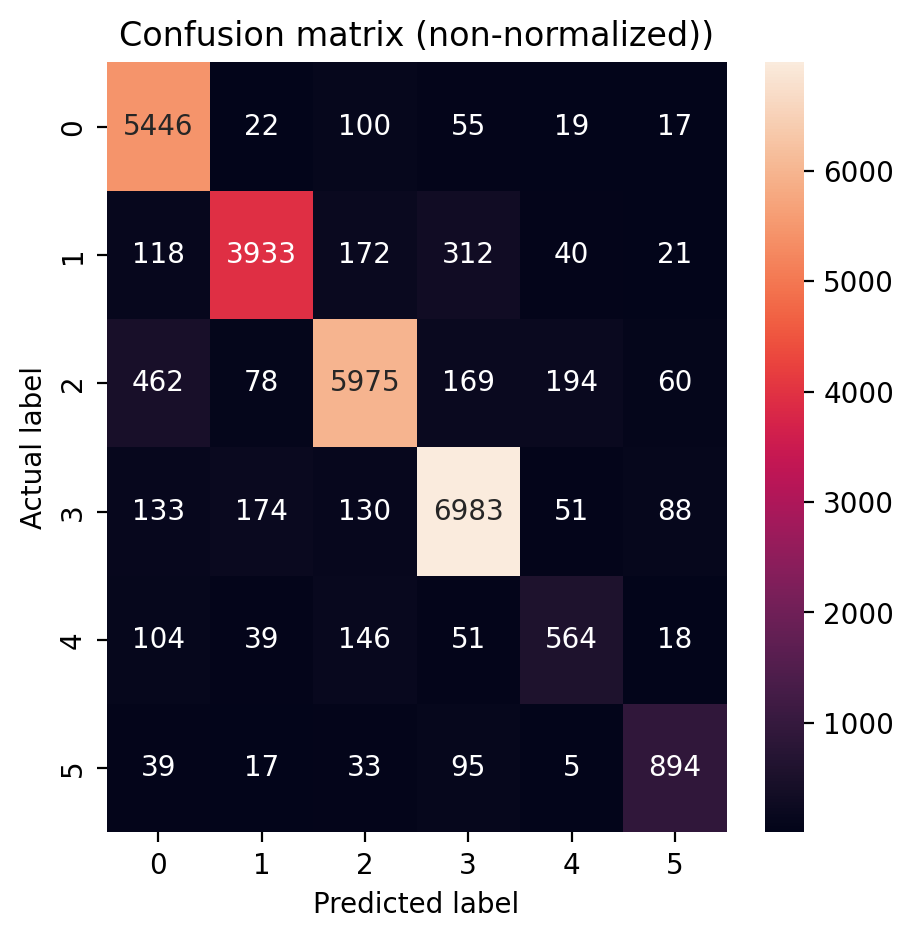

In [155]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             roc_auc_score)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

report = classification_report(y_test, y_pred)
print(report)


def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix (non-normalized))")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")


plot_cm(y_test, y_pred)